In [2]:
# Core libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)


### Load and Label all files

In [3]:
import os, re, pandas as pd, numpy as np

def load_sisfall_dataset(root="SisFall_dataset"):
    all_signals, all_labels, meta = [], [], []

    # Constants for bit-to-physical conversion
    g_factor_ADXL345 = (2*16)/(2**13)
    g_factor_MMA8451Q = (2*8)/(2**14)
    deg_factor_ITG3200 = (2*2000)/(2**16)

    for subj_folder in sorted(os.listdir(root)):
        subj_path = os.path.join(root, subj_folder)
        if not os.path.isdir(subj_path):
            continue

        for file in sorted(os.listdir(subj_path)):
            if not file.endswith(".txt"):
                continue

            # Label from filename prefix (Fxx → fall=1, Dxx → ADL=0)
            label = 1 if file.startswith("F") else 0

            df = pd.read_csv(os.path.join(subj_path, file),
                             sep='[;,\\s]+', engine='python', header=None)
            df = df.dropna(axis=1, how='all')
            if df.shape[1] < 9:    # skip corrupted
                continue
            df = df.iloc[:, :9].astype(np.float32)

            # Convert to physical units
            df.iloc[:, 0:3] *= g_factor_ADXL345
            df.iloc[:, 3:6] *= deg_factor_ITG3200
            df.iloc[:, 6:9] *= g_factor_MMA8451Q

            all_signals.append(df.values)
            all_labels.append(label)
            meta.append({
                "file": file,
                "subject": subj_folder,
                "samples": len(df),
                "label": label
            })

    print(f"Loaded {len(all_signals)} recordings "
          f"({sum(all_labels)} falls, {len(all_labels)-sum(all_labels)} ADL)")
    return all_signals, np.array(all_labels), pd.DataFrame(meta)


In [4]:
signals, labels, meta = load_sisfall_dataset("SisFall_dataset")
meta.head()


Loaded 4505 recordings (1798 falls, 2707 ADL)


,file,subject,samples,label
0,D01_SA01_R01.txt,SA01,19999,0
1,D02_SA01_R01.txt,SA01,20000,0
2,D03_SA01_R01.txt,SA01,20000,0
3,D04_SA01_R01.txt,SA01,20000,0
4,D05_SA01_R01.txt,SA01,5000,0


### Windowing the sequences
Why? Important so that models can consume equal sized inputs. We will proceed by creating fixed-length windows i.e 1s = 200 samples

In [5]:
def create_windows(signals, labels, window_size=200, overlap=0.5):
    X, y = [], []
    step = int(window_size * (1 - overlap))
    for sig, lab in zip(signals, labels):
        for i in range(0, len(sig) - window_size, step):
            window = sig[i:i+window_size]
            X.append(window)
            y.append(lab)
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.int64)
    print(f"Created {len(X)} windows of shape {X.shape[1:]}")
    return X, y

X, y = create_windows(signals, labels, window_size=200, overlap=0.5)


Created 149632 windows of shape (200, 9)


#### Check: How many 1-second windows are created for ADLs vs Falls

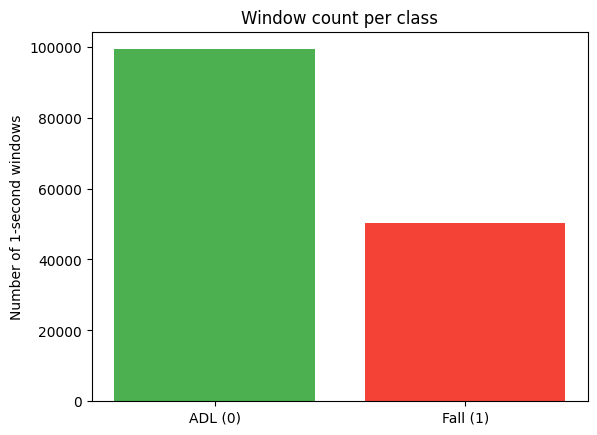

In [6]:
import matplotlib.pyplot as plt

unique, counts = np.unique(y, return_counts=True)
plt.bar(["ADL (0)", "Fall (1)"], counts, color=["#4caf50", "#f44336"])
plt.title("Window count per class")
plt.ylabel("Number of 1-second windows")
plt.show()


This helps confirm that the dataset is imbalanced i.e falls are much rarer. 

#### Visualization of a single 1-second window

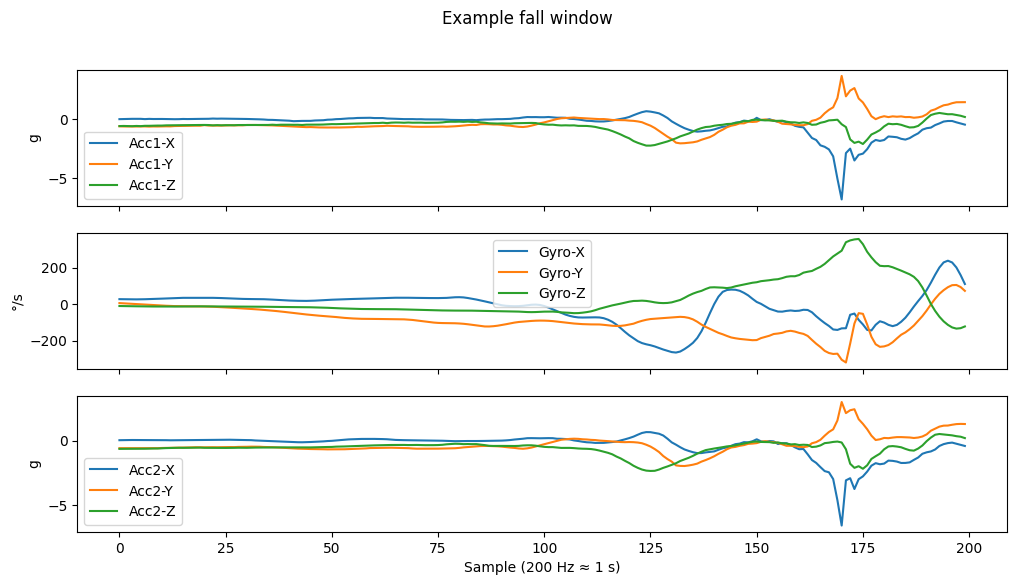

In [7]:
import random
idx = random.choice(np.where(y == 1)[0])  # pick a fall window
window = X[idx]

fig, axes = plt.subplots(3, 1, figsize=(12,6), sharex=True)
axes[0].plot(window[:,0], label="Acc1-X")
axes[0].plot(window[:,1], label="Acc1-Y")
axes[0].plot(window[:,2], label="Acc1-Z")
axes[0].legend(); axes[0].set_ylabel("g")

axes[1].plot(window[:,3], label="Gyro-X")
axes[1].plot(window[:,4], label="Gyro-Y")
axes[1].plot(window[:,5], label="Gyro-Z")
axes[1].legend(); axes[1].set_ylabel("°/s")

axes[2].plot(window[:,6], label="Acc2-X")
axes[2].plot(window[:,7], label="Acc2-Y")
axes[2].plot(window[:,8], label="Acc2-Z")
axes[2].legend(); axes[2].set_ylabel("g")
axes[2].set_xlabel("Sample (200 Hz ≈ 1 s)")
plt.suptitle("Example fall window")
plt.show()


We can see that fall occurs when there's a spike in acceleration and gyroscope readings. 

#### Compare Fall vs ADL signals

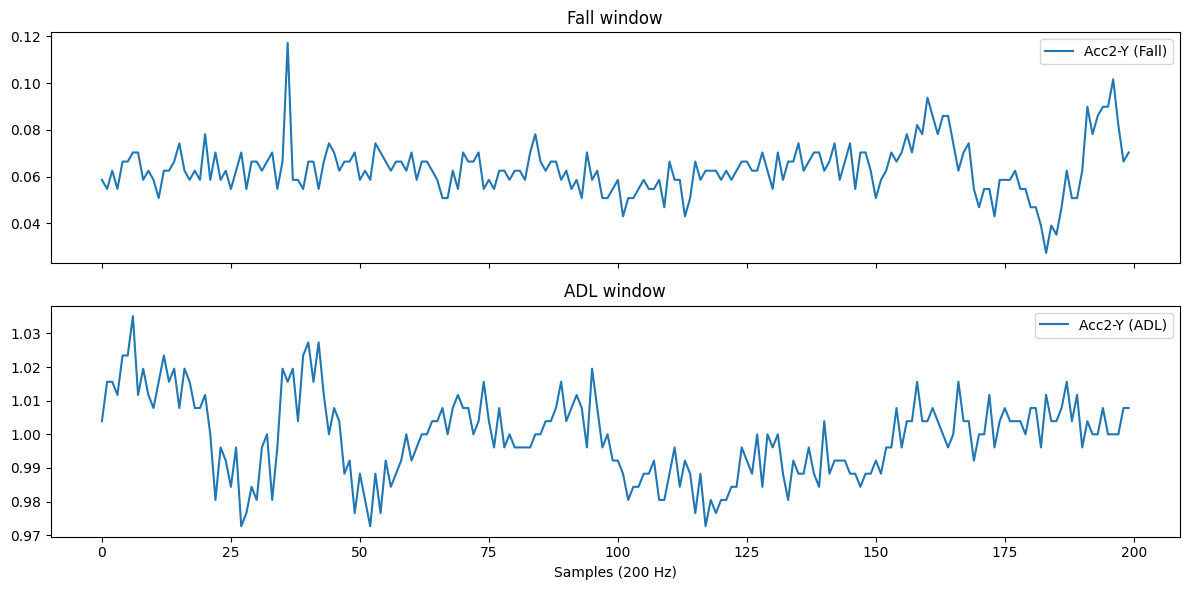

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)

fall_idx = random.choice(np.where(y == 1)[0])
adl_idx  = random.choice(np.where(y == 0)[0])

axes[0].plot(X[fall_idx][:,0], label="Acc2-Y (Fall)")
axes[0].set_title("Fall window")
axes[0].legend()

axes[1].plot(X[adl_idx][:,0], label="Acc2-Y (ADL)")
axes[1].set_title("ADL window")
axes[1].legend()

plt.xlabel("Samples (200 Hz)")
plt.tight_layout()
plt.show()


Assumption: 
The ADL curve has smaller amplitude variations whereas the fall curve shows an abrupt, high magnitude spike around the impact moment.

#### Normalize windows + train/val/test split

In [9]:
from sklearn.model_selection import train_test_split

# Ensure correct dtypes
X = X.astype(np.float32)
y = y.astype(np.int64)

print("Raw X shape:", X.shape)  # (num_windows, T=200, C=9)
print("Class counts:", np.bincount(y))

# Train / val / test split (stratified to keep class ratio)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Normalize using train stats (per channel)
mean = X_train.mean(axis=(0, 1), keepdims=True)
std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-6

X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std
X_test  = (X_test  - mean) / std

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

Raw X shape: (149632, 200, 9)
Class counts: [99287 50345]
Train/Val/Test shapes: (104742, 200, 9) (22445, 200, 9) (22445, 200, 9)


#### PyTorch Dataset + DataLoaders

In [10]:
class SisFallWindows(Dataset):
    def __init__(self, X, y):
        # X: (N, T, C) -> (N, C, T) for Conv1d
        self.X = torch.from_numpy(X).permute(0, 2, 1).contiguous()
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128

train_ds = SisFallWindows(X_train, y_train)
val_ds   = SisFallWindows(X_val, y_val)
test_ds  = SisFallWindows(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

#### 1D CNN model for fall vs ADL

In [11]:
class FallDetectorCNN(nn.Module):
    def __init__(self, in_channels=9, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),        # 200 -> 100

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),        # 100 -> 50

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1) # -> (batch, 128, 1)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)        # (B, 128, 1)
        x = x.squeeze(-1)           # (B, 128)
        logits = self.classifier(x) # (B, 2)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FallDetectorCNN().to(device)

#### Handle class imbalance + training loop

Falls will be rarer than ADLs. Use class weights:

In [12]:
# Class weights (inverse frequency)
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
class_weights = len(y_train) / (num_classes * class_counts.astype(np.float32))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Training + simple early-stopping on validation F1:

In [13]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y_batch.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = total_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average="binary")
    return avg_loss, f1


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = total_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average="binary")
    return avg_loss, f1, all_labels, all_preds


best_val_f1 = 0
patience = 5
epochs_no_improve = 0
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train_loss, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} F1: {train_f1:.3f} | "
          f"Val Loss: {val_loss:.4f} F1: {val_f1:.3f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_fall_detector_cnn.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break

# Load best model
model.load_state_dict(torch.load("best_fall_detector_cnn.pt", map_location=device))

Epoch 01 | Train Loss: 0.4470 F1: 0.715 | Val Loss: 0.4108 F1: 0.743
Epoch 02 | Train Loss: 0.3981 F1: 0.748 | Val Loss: 0.3968 F1: 0.746
Epoch 03 | Train Loss: 0.3724 F1: 0.767 | Val Loss: 0.3684 F1: 0.775
Epoch 04 | Train Loss: 0.3531 F1: 0.782 | Val Loss: 0.3480 F1: 0.781
Epoch 05 | Train Loss: 0.3408 F1: 0.791 | Val Loss: 0.3348 F1: 0.793
Epoch 06 | Train Loss: 0.3277 F1: 0.798 | Val Loss: 0.3078 F1: 0.816
Epoch 07 | Train Loss: 0.3161 F1: 0.807 | Val Loss: 0.3003 F1: 0.816
Epoch 08 | Train Loss: 0.3056 F1: 0.813 | Val Loss: 0.2969 F1: 0.822
Epoch 09 | Train Loss: 0.2994 F1: 0.816 | Val Loss: 0.2916 F1: 0.827
Epoch 10 | Train Loss: 0.2923 F1: 0.821 | Val Loss: 0.2942 F1: 0.827
Epoch 11 | Train Loss: 0.2838 F1: 0.826 | Val Loss: 0.2790 F1: 0.830
Epoch 12 | Train Loss: 0.2791 F1: 0.829 | Val Loss: 0.2875 F1: 0.832
Epoch 13 | Train Loss: 0.2728 F1: 0.835 | Val Loss: 0.2699 F1: 0.830
Epoch 14 | Train Loss: 0.2682 F1: 0.836 | Val Loss: 0.2668 F1: 0.840
Epoch 15 | Train Loss: 0.2630 F1: 

/var/folders/z2/ns_w84j13gdbd48gnvk2np5c0000gn/T/ipykernel_1455/706989519.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_fall_de

<All keys matched successfully>

#### Final evaluation + confusion matrix

Test F1 (fall vs no-fall): 0.8729654120040691

Classification report:

              precision    recall  f1-score   support

         ADL       0.95      0.91      0.93     14893
        Fall       0.84      0.91      0.87      7552

    accuracy                           0.91     22445
   macro avg       0.90      0.91      0.90     22445
weighted avg       0.91      0.91      0.91     22445



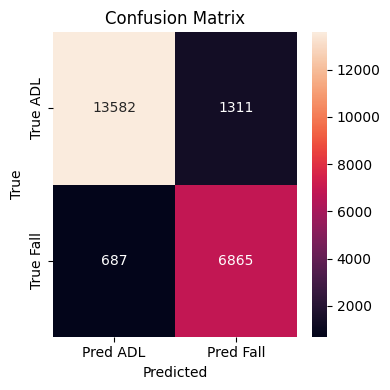

In [14]:
test_loss, test_f1, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print("Test F1 (fall vs no-fall):", test_f1)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=["ADL", "Fall"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Pred ADL","Pred Fall"],
            yticklabels=["True ADL","True Fall"])
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

#### Simulate  Fall Function

In [15]:
def simulate_realtime_fall(model, raw_signal, mean, std,
                           window_size=200, step=50,
                           fs=200, threshold=0.7):
    """
    raw_signal: (T, 9) numpy array from one recording (before windowing)
    mean, std: from training (shape (1,1,9))
    """
    model.eval()
    raw_signal = raw_signal.astype(np.float32)
    
    # Normalize with same stats (broadcast over time)
    norm_signal = (raw_signal - mean.squeeze(0)) / std.squeeze(0)

    times = []
    probs = []
    alerts = []

    with torch.no_grad():
        for start in range(0, len(norm_signal) - window_size, step):
            end = start + window_size
            window = norm_signal[start:end]            # (T, 9)
            x = torch.from_numpy(window).unsqueeze(0)  # (1, T, 9)
            x = x.permute(0, 2, 1).to(device)          # (1, 9, T)

            logits = model(x)
            prob_fall = torch.softmax(logits, dim=1)[0, 1].item()

            # center time of the window
            t_center = (start + window_size / 2) / fs  # in seconds

            times.append(t_center)
            probs.append(prob_fall)

            if prob_fall >= threshold:
                alerts.append((t_center, prob_fall))

    print("Alerts triggered at:")
    for t, p in alerts:
        print(f"  t = {t:.2f} s, P(fall) = {p:.2f}")

    # Optional: plot probability over time
    plt.figure(figsize=(10,4))
    plt.plot(times, probs)
    plt.axhline(threshold, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel("P(fall)")
    plt.title("Real-time fall probability over time")
    plt.tight_layout()
    plt.show()

    return times, probs, alerts

#### "Real-time" pre-impact simulation

Alerts triggered at:
  t = 0.50 s, P(fall) = 0.99
  t = 0.75 s, P(fall) = 0.96
  t = 1.00 s, P(fall) = 0.93
  t = 1.50 s, P(fall) = 1.00
  t = 1.75 s, P(fall) = 0.99
  t = 2.00 s, P(fall) = 1.00
  t = 2.25 s, P(fall) = 0.99
  t = 2.50 s, P(fall) = 0.83
  t = 2.75 s, P(fall) = 0.95
  t = 3.00 s, P(fall) = 0.92
  t = 3.25 s, P(fall) = 0.97
  t = 3.50 s, P(fall) = 0.92
  t = 3.75 s, P(fall) = 0.86
  t = 4.00 s, P(fall) = 0.86
  t = 4.25 s, P(fall) = 0.86
  t = 4.50 s, P(fall) = 0.76
  t = 4.75 s, P(fall) = 0.91
  t = 5.00 s, P(fall) = 0.88
  t = 5.50 s, P(fall) = 0.97
  t = 6.50 s, P(fall) = 0.92
  t = 6.75 s, P(fall) = 1.00
  t = 7.00 s, P(fall) = 1.00
  t = 7.25 s, P(fall) = 1.00
  t = 7.50 s, P(fall) = 1.00
  t = 7.75 s, P(fall) = 1.00
  t = 8.00 s, P(fall) = 1.00
  t = 8.25 s, P(fall) = 1.00
  t = 8.50 s, P(fall) = 1.00
  t = 8.75 s, P(fall) = 1.00
  t = 9.00 s, P(fall) = 1.00
  t = 9.25 s, P(fall) = 1.00
  t = 9.50 s, P(fall) = 1.00
  t = 9.75 s, P(fall) = 1.00
  t = 10.00 s, P(fall)

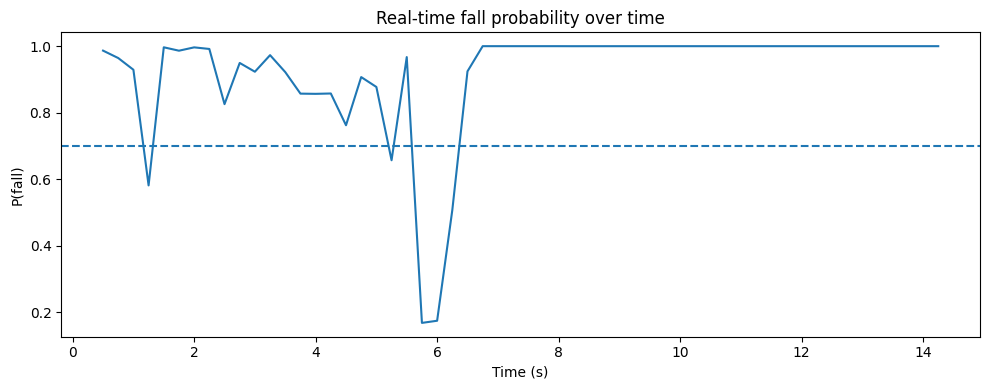

In [18]:
# Pick one fall recording
fall_indices = np.where(np.array(labels) == 1)[0]
test_fall_idx = fall_indices[0]

fall_signal = signals[test_fall_idx]  # shape (T, 9)
times, probs, alerts = simulate_realtime_fall(
    model, fall_signal, mean, std,
    window_size=200, step=50, fs=200, threshold=0.7
)

Here we can see that our model predicted fall probability >0.8 for several seconds before impact, providing an estimated 3–4 second early-warning window for caregivers.

The dip appears at the exact moment of impact. During this period, the sliding window contains a mixture of falling motion, impact shock, and post-fall stillness, which briefly confuses the classifier. Once the impact is complete and the signal stabilizes, the model correctly identifies the fall with high confidence again.